<a href="https://colab.research.google.com/github/softmurata/AudioML/blob/main/texttospeech/Bert_Vits2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Docs](https://zenn.dev/litagin/articles/37c5ed78bd7935)

In [ ]:
!git clone https://github.com/litagin02/Style-Bert-VITS2.git

In [ ]:
%cd /content/Style-Bert-VITS2
!pip install -r requirements.txt

In [ ]:
# Download pretrained models
%cd /content/Style-Bert-VITS2
!python initialize.py

Caution

In [ ]:
# 全てshare=Trueとして行う。

Only Inference with pretrained models

In [ ]:
%cd /content/Style-Bert-VITS2
!python app.py

Training

In [ ]:
!apt install libcublas11

In [ ]:
# dataset作成
%cd /content/Style-Bert-VITS2
!python webui_dataset.py

In [ ]:
# training
%cd /content/Style-Bert-VITS2
!python webui_train.py

Create Style vectors

In [17]:
# clusterint.ipynbで作成。
import os
import numpy as np

name = "anya"
wav_dir = f"Data/{name}/wavs"

embs = []
names= []
for file in os.listdir(wav_dir):
    if file.endswith(".npy"):
        xvec = np.load(os.path.join(wav_dir, file))
        embs.append(np.expand_dims(xvec, axis=0))
        names.append(file)


x = np.concatenate(embs, axis=0)
x = np.squeeze(x)
print(x.shape)

(26, 256)


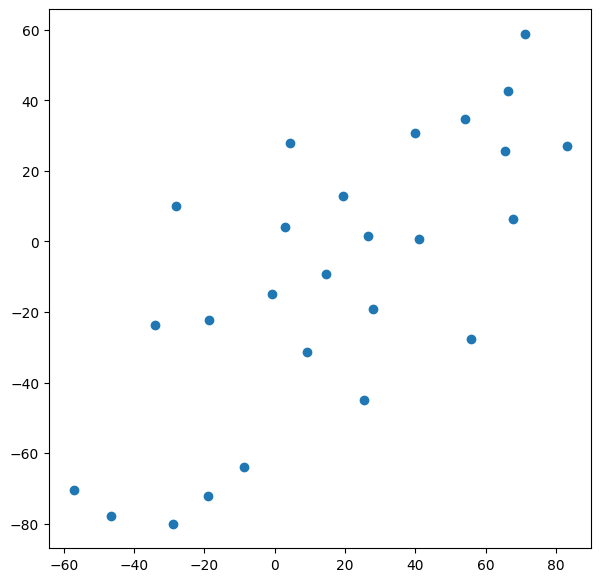

In [19]:
# TSNEで可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# 特徴量の関係か、コサイン距離が良さげ
perplexity = 5
tsne = TSNE(n_components=2, random_state=42, metric="cosine", perplexity=perplexity)

x_tsne = tsne.fit_transform(x)

plt.figure(figsize=(7, 7))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])

plt.show()

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering

method = "k"
n_clusters = 2

if method == "k":
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif method == "a":
    model = AgglomerativeClustering(n_clusters=n_clusters)

y_predict = model.fit_predict(x)

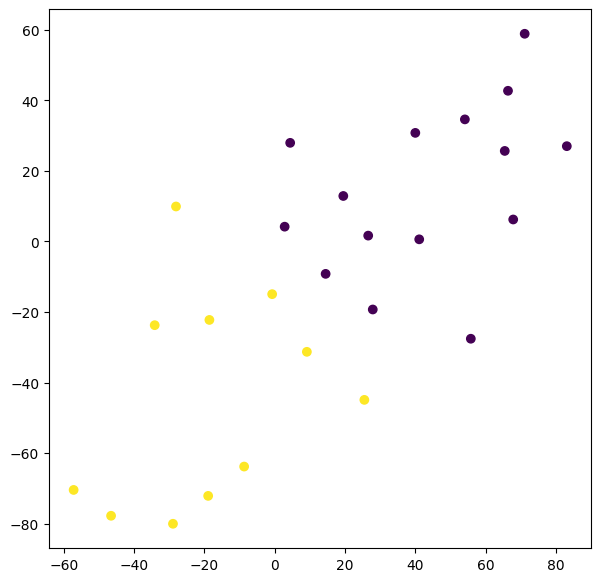

In [21]:
y_predict = model.fit_predict(x_tsne)
centroids = []
for i in range(n_clusters):
    centroids.append(x[y_predict == i].mean(axis=0))
# TSNEで可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_predict)

plt.show()

In [22]:
from scipy.spatial.distance import cdist
from IPython.display import Audio, display

# 各クラスターのセントロイドに最も近い点に対応するファイル名を取得
closest_files = []
for center_idx in range(len(centroids)):
    closest_idx = np.argmin(
        cdist(centroids[center_idx : center_idx + 1], x, metric="cosine")
    )
    closest_files.append(names[closest_idx])

# 対応する音声ファイルをJupyterノートブック上で再生
for file_name in closest_files:
    wav_path = os.path.join(wav_dir, file_name.replace(".npy", ""))
    if os.path.exists(wav_path):
        print(wav_path)
        display(Audio(wav_path))

Data/anya/wavs/0005-2.wav


Data/anya/wavs/0015-0.wav


In [23]:
# meanとcentroidを保存
mean = x.mean(axis=0)
save_vectors = np.vstack([mean, centroids])
os.makedirs(f"model_assets/{name}", exist_ok=True)
np.save(f"model_assets/{name}/style_vectors.npy", save_vectors)

In [ ]:
# 少ないサンプルでやってしまうと上手くいかない。
# おそらくtsne perplexity = 30でやっているのでそれより下のサンプルだとダメそう
# https://bunsekikobako.com/t-sne-code-example/
%cd /content/Style-Bert-VITS2
!python webui_style_vectors.py

In [24]:
# inference with trained models
%cd /content/Style-Bert-VITS2
!python app.py

/content/Style-Bert-VITS2
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a909bd2831d800b53b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
12-29 04:25:26 |  INFO  | utils.py:168 | Loaded 'model_assets/anya/anya_e100_s1300.safetensors' (iteration 100)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a909bd2831d800b53b.gradio.live
